In [ ]:
!git clone https://github.com/lyhue1991/eat_tensorflow2_in_30_days.git

Cloning into 'eat_tensorflow2_in_30_days'...
remote: Enumerating objects: 14617, done.
remote: Total 14617 (delta 0), reused 0 (delta 0), pack-reused 14617
Receiving objects: 100% (14617/14617), 59.86 MiB | 27.49 MiB/s, done.
Resolving deltas: 100% (13233/13233), done.
Checking out files: 100% (12529/12529), done.


In [ ]:
%ls

eat_tensorflow2_in_30_days/  sample_data/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [ ]:
df_train_raw = pd.read_csv('./eat_tensorflow2_in_30_days/data/titanic/train.csv')
df_test_raw = pd.read_csv('./eat_tensorflow2_in_30_days/data/titanic/test.csv')
df_train_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


字段说明：

- Survived:0代表死亡，1代表存活【y标签】
- Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】

- Name:乘客姓名 【舍去】
- Sex:乘客性别 【转换成bool特征】
- Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
- SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
- Parch:乘客父母/孩子的个数(整数值)【数值特征】
- Ticket:票号(字符串)【舍去】
- Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
- Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
- Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

## 1. EDA（Exploratory Data Analysis）

Text(0.5, 0, 'Survived')

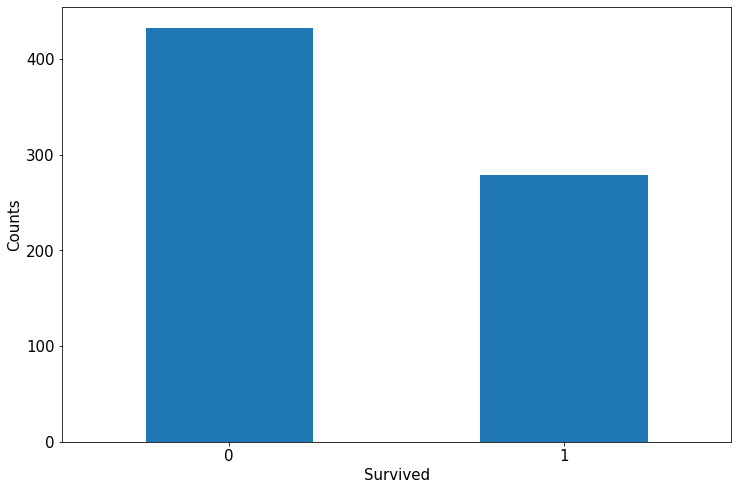

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

ax = df_train_raw['Survived'].value_counts().plot(
    kind='bar',
    figsize=(12, 8),
    fontsize=15,
    rot=0  # 轴旋转角度
)
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Survived', fontsize=15)

Text(0.5, 0, 'Age')

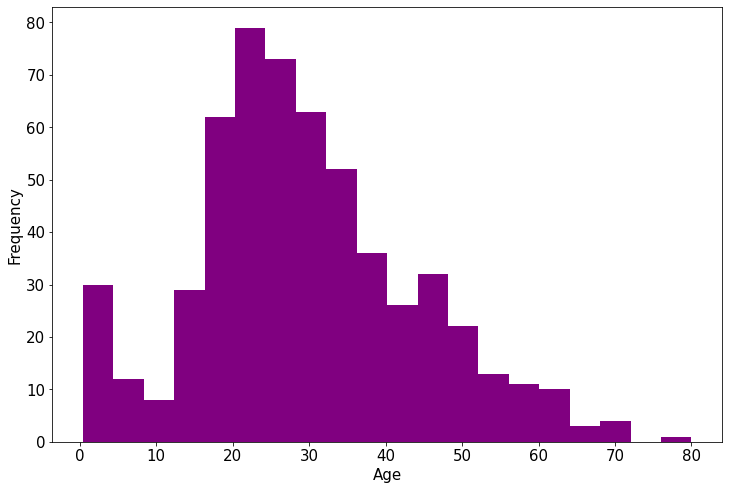

In [ ]:
ax = df_train_raw['Age'].plot(
    kind='hist',
    bins=20,
    color='purple',
    figsize=(12, 8),
    fontsize=15
)
ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)

Text(0.5, 0, 'Age')

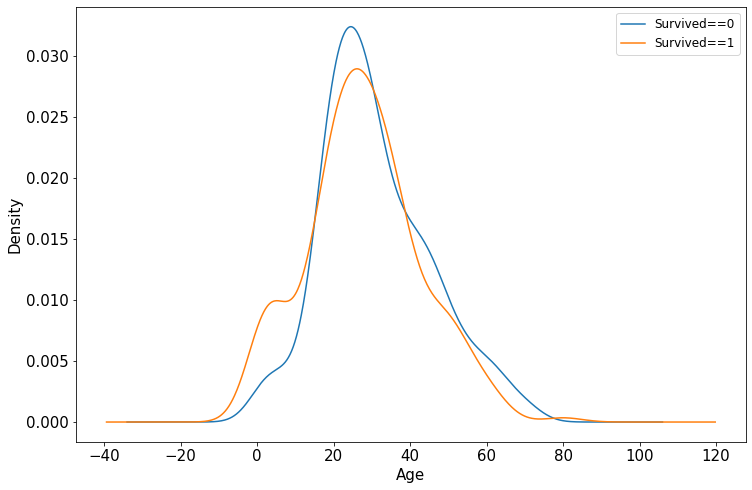

In [ ]:
ax = df_train_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
df_train_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)

## 2. 数据处理

In [ ]:
def preprocessing(data):

  df_result = pd.DataFrame()

  # Pclass
  df_Pclass = pd.get_dummies(data['Pclass'])  # 离散特征 one-hot 编码
  df_Pclass.columns = ['Pclass_' + str(x) for x in df_Pclass.columns]
  df_result = pd.concat([
               df_result,
               df_Pclass,
              ],
              axis=1   # 1 列，0 行
              )

  # Sex
  df_Sex = pd.get_dummies(data["Sex"])
  df_result = pd.concat(
      [
       df_result,
       df_Sex
      ],
      axis=1
  )

  # Age 
  df_result['Age'] = data['Age'].fillna(0)  # 使用 0 填充 Nan
  df_result['Age_null'] = pd.isna(data['Age']).astype('int32')  # 标记填充过的样本

  # SibSp,Parch,Fare
  df_result['SibSp'] = data['SibSp']
  df_result['Parch'] = data['Parch']
  df_result['Fare'] = data['Fare']


  # Carbin
  df_result['Cabin_null'] =  pd.isna(data['Cabin']).astype('int32')

  # Embarked
  df_Embarked = pd.get_dummies(data['Embarked'],dummy_na=True)  # dummy_na: bool, default False Add a column to indicate NaNs, if False NaNs are ignored.
  df_Embarked.columns = ['Embarked_' + str(x) for x in df_Embarked.columns]
  df_result = pd.concat([df_result, df_Embarked],
                        axis=1
                        )

  return(df_result)


x_train = preprocessing(df_train_raw)
y_train = df_train_raw['Survived'].values

x_test = preprocessing(df_test_raw)
y_test = df_test_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )


x_train.shape = (712, 15)
x_test.shape = (179, 15)


## 3. 定义模型

使用 Keras 接口有以下 3 种方式构建模型：
1. 使用 Sequential 按层顺序构建模型
2. 使用函数式 API 建任意结构模型
3. 继承 Model 基类构建自定义模型。

此处选择使用最简单的 Sequential，按层顺序模型。

In [ ]:
tf.keras.backend.clear_session()
# 销毁当前的TF图并创建一个新图,有助于避免旧模型/图层混乱。

model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(15,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


## 4. 训练模型

训练模型通常有 3 种方法：
1. 内置 fit 方法
2. 内置 train_on_batch 方法
3. 自定义训练循环。

选择最常用也最简单的内置 fit 方法。

In [ ]:
# 二分类问题选择二元交叉熵损失函数

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2)  # 分割部分数据进行验证


Epoch 1/30
9/9 [==============================] - 1s 44ms/step - loss: 1.0057 - auc: 0.4185 - val_loss: 0.8876 - val_auc: 0.5135
Epoch 2/30
9/9 [==============================] - 0s 7ms/step - loss: 0.7796 - auc: 0.5954 - val_loss: 0.7076 - val_auc: 0.6531
Epoch 3/30
9/9 [==============================] - 0s 7ms/step - loss: 0.6744 - auc: 0.6729 - val_loss: 0.7276 - val_auc: 0.6237
Epoch 4/30
9/9 [==============================] - 0s 8ms/step - loss: 0.6445 - auc: 0.6937 - val_loss: 0.7113 - val_auc: 0.6595
Epoch 5/30
9/9 [==============================] - 0s 8ms/step - loss: 0.6753 - auc: 0.6939 - val_loss: 0.6850 - val_auc: 0.6599
Epoch 6/30
9/9 [==============================] - 0s 8ms/step - loss: 0.6158 - auc: 0.7129 - val_loss: 0.6658 - val_auc: 0.6717
Epoch 7/30
9/9 [==============================] - 0s 7ms/step - loss: 0.6019 - auc: 0.7164 - val_loss: 0.6534 - val_auc: 0.6903
Epoch 8/30
9/9 [==============================] - 0s 6ms/step - loss: 0.6133 - auc: 0.7203 - val_loss: 

## 5. 模型评估
训练集效果：

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


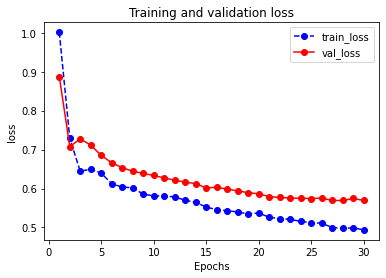

In [ ]:
plot_metric(history, 'loss')

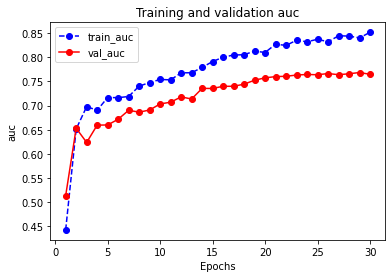

In [ ]:
plot_metric(history, "auc")

测试集效果：

In [ ]:
model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.5235 - auc: 0.7779


[0.5234608054161072, 0.7779146432876587]

## 6. 使用模型

In [ ]:
# 预测模型
model.predict(x_test[:10])

# 等价写法
# model(tf.constant(x_test[:10].values, dtype=tf.float32))

array([[0.35824636],
       [0.49074376],
       [0.5202967 ],
       [0.8668207 ],
       [0.5261116 ],
       [0.6100692 ],
       [0.36835748],
       [0.67273563],
       [0.5397028 ],
       [0.17484665]], dtype=float32)

In [ ]:
# 预测类别
model.predict_classes(x_test[:10])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

## 7. 保存模型

可以使用 Keras 方式保存模型，也可以使用 TensorFlow 原生方式保存。前者仅仅适合使用 Python 环境恢复模型，后者则可以跨平台进行模型部署。

推荐使用后一种方式进行保存。

1. Keras方式保存

In [ ]:
# 保存模型结构及权重

model.save('./eat_tensorflow2_in_30_days/data/1.h5')

del model # 删除现有模型

# 加载保存的模型
model = models.load_model('./eat_tensorflow2_in_30_days/data/1.h5')
model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.5235 - auc: 0.7779


[0.5234608054161072, 0.7779146432876587]

In [ ]:
# 保存模型结构
json_str = model.to_json()

# 恢复模型结构
model_json = models.model_from_json(json_str)

In [ ]:
# 保存模型权重
model.save_weights('./eat_tensorflow2_in_30_days/data/keras_model_weight.h5')

# 恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

# 加载权重
model_json.load_weights('./eat_tensorflow2_in_30_days/data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.5442 - auc: 0.7687


[0.5234608054161072, 0.7779146432876587]

2. TensorFlow 原生方式保存

In [ ]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./eat_tensorflow2_in_30_days/data/tf_model_weights.ckpt',save_format = "tf")

# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署
model.save('./eat_tensorflow2_in_30_days/data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./eat_tensorflow2_in_30_days/data/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)

INFO:tensorflow:Assets written to: ./eat_tensorflow2_in_30_days/data/tf_model_savedmodel/assets
export saved model.
6/6 [==============================] - 0s 2ms/step - loss: 0.5235 - auc: 0.7779


[0.5234608054161072, 0.7779146432876587]